# Word Segmentation Modelling (version : alam.2.0)

This is the modelling documentation of Word Segmentation

First Structured :


Input :

    Slides Data
    WORD2VEC 50
    

output :

    Multi Conv LSTM


## Plan

    [*] Get Data
    [*] Transform the data
    [ ] Prepare the model
    [ ] Train it

In [1]:
%matplotlib inline
import sys
sys.path.append('../scr/')
import pandas as pd
import torch
import numpy as np
import os
import pickle
import WordSegmenTools as wst
from torch.autograd import Variable
import random
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
import time

In [2]:
PATH_DATA_RAW='../../data/raw/'
PATH_DATA_CLN='../../data/clean/'
PATH_MODEL='../../data/model/'

In [3]:
os.listdir(PATH_DATA_CLN)

['.ipynb_checkpoints', 'data_clean_100k.res', 'data_train2_for_slides.res']

In [4]:
os.listdir(PATH_MODEL)

['char_embed_25.res', 'char_embed_50.res', 'char_embed_75.res']

## Get Data

In [5]:
SEQ_LENGTH=6

In [6]:
# data_cln=pd.read_csv(PATH_DATA_CLN+'data_clean_100k.res')
data_cln=pickle.load(open(PATH_DATA_CLN+'data_train2_for_slides.res','rb'))
w2v = Word2Vec.load(PATH_MODEL+"char_embed_50.res")

In [7]:
data_cln['slides_trim']=data_cln.slides.apply(lambda x: x.strip())

In [8]:
data_cln.head()

,slides,ori_len,slides_no_space,space_cnt,slides_no_space_len,slides_trim
20,katany,6,katany,0,6,katany
21,atanya,6,atanya,0,6,atanya
28,pembel,6,pembel,0,6,pembel
29,embeli,6,embeli,0,6,embeli
30,mbelia,6,mbelia,0,6,mbelia


In [9]:
## second space position should reduce by 1 in prediction
data_cln['space_position']=data_cln.slides_trim.apply(lambda x : ','.join((np.where(np.array(list(x)) == ' ')[0]).astype(str)))

In [10]:
data_cln['id']=[i for i in range(len(data_cln))]

In [11]:
data_cln.sample(10)

,slides,ori_len,slides_no_space,space_cnt,slides_no_space_len,slides_trim,space_position,id
3742218,ra tida,7,ratida,1,6,ra tida,2,1369734
1007517,nangan,6,nangan,0,6,nangan,,187015
5571241,ke apsc,8,keapsc,1,6,ke apsc,2,2191836
3597605,kan men,7,kanmen,1,6,kan men,3,1264371
548146,lovren,6,lovren,0,6,lovren,,101812
3515256,mempro,7,mempro,0,6,mempro,,1204469
4377176,ur pada,7,urpada,1,6,ur pada,2,1834039
1575072,nstagr,6,nstagr,0,6,nstagr,,291849
4425575,alah su,7,alahsu,1,6,alah su,4,1869242
1605985,dustri,6,dustri,0,6,dustri,,297616


In [12]:
data_cln.shape

(2383354, 8)

## Transform Data

In [13]:
def target_generator(x):
    basic=np.zeros(SEQ_LENGTH)
    if len(x)==0:
        return basic
    else:
        for x in x.split(','):
            basic[int(x)-1]=1
        return basic

In [14]:
target_generator('6')

array([0., 0., 0., 0., 0., 1.])

In [15]:
# data_used=pd.concat([data_cln[data_cln.space_cnt==0].sample(30000,random_state=125),
#                      data_cln[data_cln.space_cnt==1].sample(40000,random_state=125),
#                      data_cln[data_cln.space_cnt==2].sample(35000,random_state=125)])

data_used=pd.concat([data_cln[data_cln.space_cnt==0].sample(50000,random_state=125),
                     data_cln[data_cln.space_cnt==1].sample(80000,random_state=125),
                     data_cln[data_cln.space_cnt==2].sample(60000,random_state=125)])

In [16]:
len(data_used)*0.8

152000.0

In [17]:
data_used_train=data_used.sample(150000,random_state=143)
data_used_test=data_used[~(data_used.id.isin(data_used_train.id))]

In [18]:
## Target 
Y_tr=np.array(data_used_train.space_position.apply(target_generator).tolist(),dtype=np.double)
Y_te=np.array(data_used_test.space_position.apply(target_generator).tolist(),dtype=np.double)

# encoder = OneHotEncoder()
# encoder.fit(Y_tr.reshape(-1,1))

# Y_tr=encoder.transform(Y_tr.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))
# Y_te=encoder.transform(Y_te.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))

## Source
X_tr=wst.char_vectorizer_word2vec(data_used_train.slides_no_space.tolist(), w2v, SEQ_LENGTH)
X_te=wst.char_vectorizer_word2vec(data_used_test.slides_no_space.tolist(), w2v, SEQ_LENGTH)

In [19]:
X_tr.shape

(150000, 6, 50)

In [20]:
X_te.shape

(40000, 6, 50)

In [21]:
Y_tr.shape

(150000, 6)

## Prepare the Model

In [22]:
class MultiLstm(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_dim0, hidden_dim1, hidden_dim2, Layers):        
        super(MultiLstm, self).__init__()
        self.input_dim = input_size
#         self.input_cnn = input_cnn_size
        self.hidden_dim0 = hidden_dim0
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        self.layer=Layers
        # self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.relu = torch.nn.ReLU()
        self.lstm1 = torch.nn.LSTM(self.input_dim, self.hidden_dim0)
        self.lstm2 = torch.nn.LSTM(self.hidden_dim0, self.hidden_dim1)
        self.lstm3 = torch.nn.LSTM(self.hidden_dim1, self.hidden_dim2, num_layers=Layers)
        self.linear1 = torch.nn.Linear(self.hidden_dim2, self.hidden_dim2)
        self.linear2 = torch.nn.Linear(self.hidden_dim2, output_size)
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input):
        torch.manual_seed(200)
        batch_size=len(input)
        embedding_len=len(input[0][0])        
        input=input.view(batch_size,len(input[0]), -1)
        
        lstm_out, hidden1 = self.lstm1(input)
        lstm_out, hidden2 = self.lstm2(lstm_out)
        out, hidden3 = self.lstm3(lstm_out)
        
        y_pred = self.linear1(out)
        y_pred = self.linear2(y_pred)

        out_flat=y_pred.view(y_pred.size(0), -1)  
        out_flat=y_pred[:,-1]
        
#         y_pred = self.softmax(out_flat)
        y_pred = self.sigmoid(out_flat)
        
        return y_pred
    
## Remember LSTM : Batch, Seq, Embedding
## Conv : [batch_size, in_channels, Len Seq]
# p = p.transpose(1, 2).transpose(0, 1)

In [23]:
# # Get the model
# INPUT_LENGTH=50
# LAYERS=3
# HIDDEN_LAYER0=100
# HIDDEN_LAYER1=20
# HIDDEN_LAYER2=10

# OUT_DIM=6
# learningRate=0.0004

# model_coba=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1, hidden_dim2=HIDDEN_LAYER2, Layers=LAYERS)

In [24]:
# XX=torch.rand(30,6,50)
# # XX=torch.from_numpy(np.array([[[1,2,3,4],[5,6,7,8]],[[2,3,4,5],[6,7,8,9]],[[3,4,5,6],[7,8,9,0]]]))
# model_coba(XX)
# # XX[:,1]

In [25]:
def data_batching_torch(X,y,batch):
    batches=[(torch.from_numpy(X[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'),
              torch.from_numpy(y[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'))   
                  for i in range(int(len(X)/batch)+1)]
    return batches

In [26]:
BATCH_SIZE=40
training_samples=data_batching_torch(X_tr,Y_tr,BATCH_SIZE)
len(training_samples)

3751

In [27]:
random.seed(121)
sample_val=random.sample(training_samples,335)
sample_train=list(set(training_samples)-set(sample_val))

In [28]:
w2v.vector_size

50

In [29]:
# Get the model
INPUT_LENGTH=w2v.vector_size
LAYERS=3
HIDDEN_LAYER0=150
HIDDEN_LAYER1=30
HIDDEN_LAYER2=30
OUT_DIM=6
learningRate=0.05

model_clstm=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1,hidden_dim2=HIDDEN_LAYER2, Layers=LAYERS)

In [30]:
## Choose the optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()
criterion = torch.nn.MultiLabelSoftMarginLoss()
# optimizer = torch.optim.Adam(model_clstm.parameters(),lr=learningRate)
optimizer = torch.optim.SGD(model_clstm.parameters(),
                            lr=learningRate)
#                             ,weight_decay=0.05)

In [31]:
AA=training_samples[0][1]

In [32]:
AA.type()

'torch.DoubleTensor'

## Train it

In [33]:
running_loss_train_ls=[]
running_loss_test_ls=[]

In [36]:
epochs=15
model_clstm.double()

for epoch in range(epochs):
    L=time.time()
    model_clstm.train()
    running_loss_train = 0
    running_loss_test = 0
    # Converting inputs and labels to Variable
    
    for batch_idx, (data, target) in enumerate(sample_train, 1):
        if data.size()[0]>0:
            inputs = Variable(data)
            labels = Variable(target)
            optimizer.zero_grad()
            
            outputs= model_clstm(inputs)            
            
            # get loss for the predicted output
            loss = criterion(outputs, labels)
            loss.backward()
            
            # update parameters
            optimizer.step()
            running_loss_train += (loss.item() - running_loss_train) / batch_idx
            
    model_clstm.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(sample_val, 1):
            if data.size()[0]>0:
                inputs = Variable(data)
                labels = Variable(target)
                outputs= model_clstm(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += (loss.item() - running_loss_test) / batch_idx
    
    running_loss_train_ls.append(running_loss_train)
    running_loss_test_ls.append(running_loss_test)
        
    if epoch % 2 == 0:
        print('----------'+str(epoch)+'----------')
        print("running loss train", running_loss_train)
        print("running loss val", running_loss_test)
        print("time every epoch: "+str((time.time()-L)/60))

----------0----------
running loss train 0.6931878848025539
running loss val 0.6931872496170992
time every epoch: 4.673069683710734
----------2----------
running loss train 0.6931832692699176
running loss val 0.6931828549921486
time every epoch: 4.892563084761302
----------4----------
running loss train 0.693179598400271
running loss val 0.6931793336031168
time every epoch: 4.215780929724375
----------6----------
running loss train 0.6931766067708826
running loss val 0.6931764465152487
time every epoch: 61.9954913020134
----------8----------
running loss train 0.6931741203732107
running loss val 0.6931740351306338
time every epoch: 4.378161819775899
----------10----------
running loss train 0.6931720202608944
running loss val 0.6931719899370749
time every epoch: 4.400874451796214
----------12----------
running loss train 0.6931702222984732
running loss val 0.693170232819688
time every epoch: 4.22189523379008
----------14----------
running loss train 0.6931686652533031
running loss val 

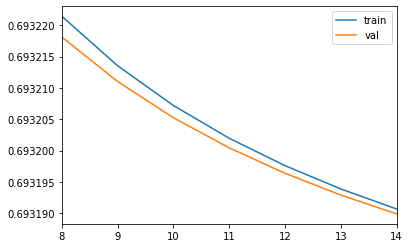

In [35]:
data_eval=pd.DataFrame({'train':running_loss_train_ls,'val':running_loss_test_ls})
data_eval[8:].plot()

In [57]:
1+1

2

In [20]:
model.eval()

ModelLstm(
  (lstm): LSTM(26, 25)
  (linear): Linear(in_features=25, out_features=15, bias=False)
  (sigmoid): Sigmoid()
)

In [21]:
## Training
XX=X_tr.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [33]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [34]:
data_used_train['y_pred']=yy0

In [36]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
50144,melainkandaerah,melainkan daerah,1637189,000000001000000,000000000000000
67640,menegaskantiket,menegaskan tiket,1719973,000000000100000,000000000000000
87884,pelakusetiapini,pelaku setiap ini,1815936,000001000001000,000000000000000
32800,tahunberbobotdi,tahun berbobot di,1554907,000010000000100,000000000000000
60884,terpopulerdalam,terpopuler dalam,1687901,000000000100000,000000000000000
15182,identikinisudah,identik ini sudah,1471301,000000100100000,000000000000000
65497,denganpekerjaan,dengan pekerjaan,1709857,000001000000000,000000000000000
48114,mobiltahunsedan,mobil tahun sedan,1627587,000010000100000,000000000000000
58791,terkaitterhadap,terkait terhadap,1678152,000000100000000,000000000000000
31506,sertatariftahap,serta tarif tahap,1548878,000010000100000,000000000000000


## Test it

In [37]:
## Test it
XX=X_te.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [38]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [39]:
data_used_test['y_pred']=yy0

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
12342,sepakperusahaan,sepak perusahaan,1457750,000010000000000,000000000000000
9138,miliarmelakukan,miliar melakukan,1442854,000001000000000,000000000000000
3403,asalpendaftaran,asal pendaftaran,1416167,000100000000000,000000000000000
74342,jelasnyastadium,jelasnya stadium,1751813,000000010000000,000000000000000
12597,cmnphargaplakat,cmnp harga plakat,1459043,000100001000000,000000000000000
86940,bahwadenganyang,bahwa dengan yang,1811573,000010000010000,000000000000000
54344,terjadibniingin,terjadi bni ingin,1657235,000000100100000,000000000000000
8989,untuktetappiper,untuk tetap piper,1442103,000010000100000,000000000000000
15108,ratelalusamping,rate lalu samping,1471008,000100010000000,000000000000000
28477,danyangnokiadwi,dan yang nokia dwi,1534286,001000100001000,000000000000000
